In [72]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Input, Dropout, Flatten, Lambda
from tensorflow.keras.applications import EfficientNetB6, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import Callback

In [5]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(f'train_instaces: {len(X_train)} and test_instances: {len(X_test)}')
print(np.unique(y_train))

train_instaces: 60000 and test_instances: 10000
[0 1 2 3 4 5 6 7 8 9]


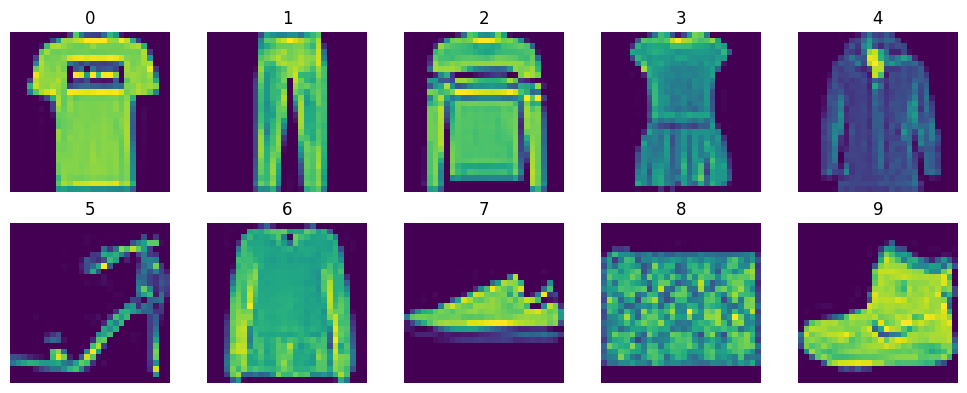

In [6]:
fig, axs = plt.subplots(2, 5, figsize = (10, 4))
ax = axs.ravel()
for i in range(10):
    ax[i].imshow(X_train[np.where(y_train == i)[0][0]])
    ax[i].axis('off')
    ax[i].set_title(i)

plt.tight_layout()
plt.show()

In [7]:
X_train = X_train / 255
X_test = X_test / 255

In [8]:
X_valid = X_train[:5000]
y_valid = y_train[:5000]

X_train = X_train[5000:]
y_train = y_train[5000:]

In [9]:
X_train[0].shape

(28, 28)

In [34]:
def cov_model():
    input_layer = Input((28, 28, 1))
    x = Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(input_layer)
    x = MaxPool2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(x)
    x = MaxPool2D(pool_size = (2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(filters = 128, kernel_size = (3,3), strides = 1, padding = 'same', activation = 'relu')(x)
    x = MaxPool2D(pool_size = (2, 2))(x)
    x = Dropout(0.1)(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dense(128, activation = 'relu')(x)
    output_layer = Dense(10, activation = 'sigmoid')(x)
    return tf.keras.Model(input_layer, output_layer)

c:\Users\achen\Documents\1Code\notebook_stuff\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


loss: 0.805023 - val_loss: 0.789774
loss: 0.659234 - val_loss: 0.745944
loss: 0.593414 - val_loss: 0.559763
loss: 0.547120 - val_loss: 0.478036


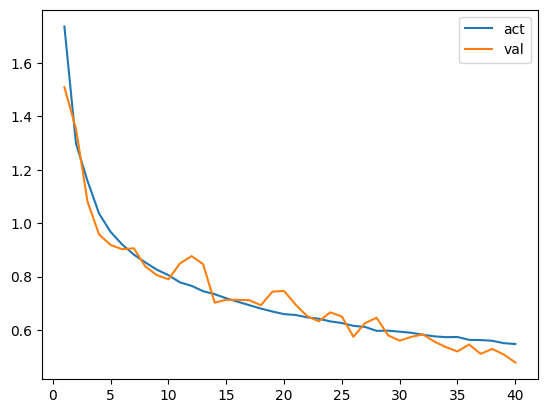

In [92]:
class Epochs(Callback):
    def __init__(self, epoch):
        super().__init__()
        self.epoch = epoch
    def on_epoch_end(self, epo, logs = None):
        if (epo + 1) % self.epoch == 0:
            print(f"loss: {logs['loss']:.6f} - val_loss: {logs.get('val_loss', 'N/A'):.6f}")


def run_model(X, y, X_val, y_val, epo = 5):
    aug_train = ImageDataGenerator(
        horizontal_flip = True,
        rotation_range = 45,
        vertical_flip = True,
        zoom_range = [1, 1.5],
        height_shift_range = 0.1,
        width_shift_range = 0.1)
    
    X = np.expand_dims(X, axis = -1)
    data = aug_train.flow(X, y = y)

    model = cov_model()
    model.compile(optimizer = SGD(), loss = sparse_categorical_crossentropy)
    history = model.fit(data, epochs = epo, validation_data = (X_val, y_val), verbose = 0, callbacks = [Epochs(10)])

    plt.figure()
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label = 'act')
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['val_loss'], label = 'val')
    plt.legend()
    plt.show()
    
    return model, model.get_weights()

model_1, model_weights = run_model(X_train.copy(), y_train, X_valid, y_valid, 40)

In [93]:
(np.argmax(model_1.predict(X_test, verbose = 0), axis = 1) == y_test).sum() / len(y_test)

0.8091

In [85]:
def tl_cov(learn = False):
    input_layer = Input((28, 28, 3))
    x = tf.keras.layers.Resizing(48, 48)(input_layer)
    pre_mdl = VGG16(include_top = False, input_tensor = x, pooling = 'avg')
    pre_mdl.trainable = False
    pre_mdl.layers[-1].trainable = True
    if learn is True:
        for layer in pre_mdl.layers[-10:]:
            layer.trainable = True
    fin_layer = pre_mdl.output
    x = Flatten()(fin_layer)
    x = Dense(512, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    output_layer = Dense(10, activation = 'sigmoid')(x)
    return tf.keras.Model(input_layer, output_layer)

c:\Users\achen\Documents\1Code\notebook_stuff\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


loss: 0.894506 - val_loss: 0.860504
loss: 0.815542 - val_loss: 0.790848


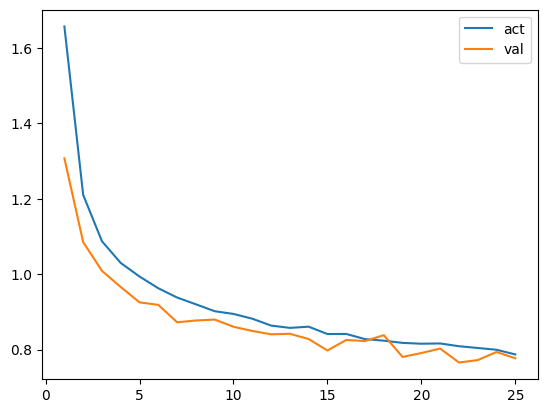

loss: 0.512480 - val_loss: 0.507376
loss: 0.425741 - val_loss: 0.460207


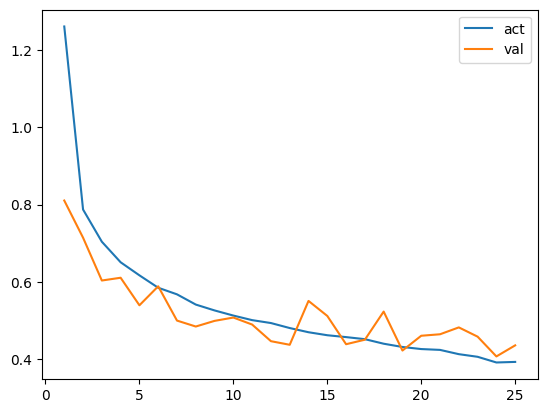

In [96]:
def show_im(history):
    plt.figure()
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label = 'act')
    plt.plot(np.arange(1, len(history.history['loss']) + 1), history.history['val_loss'], label = 'val')
    plt.legend()
    plt.show()

def tl_run(X, y, X_val, y_val, epo = 5, weights = None, trainable = False):
    aug_train = ImageDataGenerator(
        horizontal_flip = True,
        rotation_range = 45,
        vertical_flip = True,
        height_shift_range = 0.1,
        width_shift_range = 0.1)
    
    data = aug_train.flow(X, y = y, batch_size = 64)

    if trainable is False:
        model = tl_cov(learn = True)
        model.set_weights(weights)
        model.compile(optimizer = SGD(), loss = sparse_categorical_crossentropy)
        history = model.fit(data, epochs = epo, validation_data = (X_val, y_val), verbose = 0, callbacks = [Epochs(10)])
        show_im(history)
    else:
        model = tl_cov()
        model.compile(optimizer = SGD(), loss = sparse_categorical_crossentropy)
        history = model.fit(data, epochs = epo, validation_data = (X_val, y_val), verbose = 0, callbacks = [Epochs(10)])
        show_im(history)
        if trainable is True:
            tl_run(X, y, X_val, y_val, epo = 25, weights = model.get_weights(), trainable = False)
    
    return model

model_2 = tl_run(np.dstack([X_train.copy()[:15000]] * 3).reshape(-1, 28, 28, 3), y_train[:15000], np.dstack([X_valid.copy()] * 3).reshape(-1, 28, 28, 3), y_valid, 25, trainable = True)

In [97]:
(np.argmax(model_2.predict(np.dstack([X_test.copy()] * 3).reshape(-1, 28, 28, 3), verbose = 0), axis = 1) == y_test).sum() / len(y_test)

# Worse performance, but it's down to weak computation. Have to increase batch size, reduce image input, and reduce epoch, since training takes far too long on this more complex model
# (2 hours to run this)

0.6948